In [1]:
import os
from functools import partial
import torch
import numpy as np
import numpy.random as rnd
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

In [2]:
from torch import nn
from pyro.nn import PyroModule

assert issubclass(PyroModule[nn.Linear], nn.Linear)
assert issubclass(PyroModule[nn.Linear], PyroModule)

In [3]:
from pyro.nn import module
from pyro.nn import PyroSample
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
from pyro.infer import Predictive
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.contrib.bnn import HiddenLayer

## Data

In [4]:
# Time horizon
T = 300
t = np.arange(T)

In [5]:
# Input signal
num_freq = 100
Ω = rnd.rand(num_freq)*0.2
u = np.zeros((T+1,num_freq))
for i,ω in enumerate(Ω):
    u[:,i] = np.cos(ω* np.append(t, T))
    
u = np.mean(u, axis=1)

In [6]:
# Input signal
y = np.zeros((T))

# Quadratic output function
y[:] = 0.4*u[1:T+1]**2 - 0.4*u[0:T]

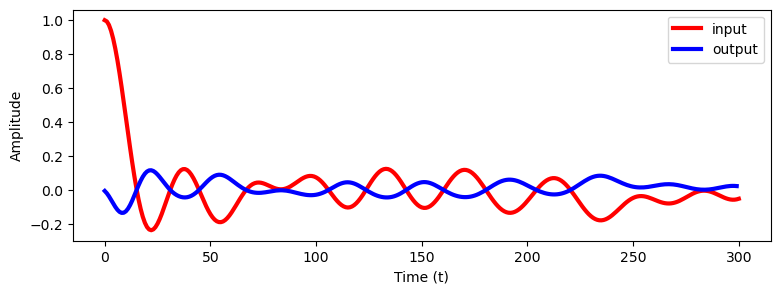

In [7]:
# Plot generated input signal
fig = plt.figure(figsize=(9,3))
ax = fig.add_subplot(111)
ax.plot(u, c="red", lw=3, label="input");
ax.plot(y, c="blue", lw=3, label="output"); 
ax.set_xlabel("Time (t)");
ax.set_ylabel("Amplitude");
ax.legend();

In [8]:
# Store lag-input as features
x = np.vstack([u[1:], u[0:T]]).T

# Cast to tensors
x_data = torch.tensor(x, dtype=torch.float)
y_data = torch.tensor(y, dtype=torch.float)

## Model 1: Bayesian linear regression

In [9]:
class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

In [10]:
# Define model and inference procedure
model = BayesianRegression(2, 1)
guide = AutoDiagonalNormal(model)
adam = Adam({"lr": 0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

In [11]:
pyro.clear_param_store()

# Train model
num_iterations = 1500
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x_data, y_data)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / T))

[iteration 0001] loss: 3.3150
[iteration 0101] loss: 2.5512
[iteration 0201] loss: -1.0156
[iteration 0301] loss: -2.0195
[iteration 0401] loss: -1.9749
[iteration 0501] loss: -2.0754
[iteration 0601] loss: -2.0796
[iteration 0701] loss: -2.0830
[iteration 0801] loss: -2.0788
[iteration 0901] loss: -2.0765
[iteration 1001] loss: -2.0773
[iteration 1101] loss: -2.0815
[iteration 1201] loss: -2.0782
[iteration 1301] loss: -2.0271
[iteration 1401] loss: -2.0822


### Model evaluation

In [12]:
def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats

# Make predictions
predictive = Predictive(model, guide=guide, num_samples=800, return_sites=("linear.weight", "obs", "_RETURN"))
samples = predictive(x_data)
pred_summary = summary(samples)
mu = pred_summary["_RETURN"]

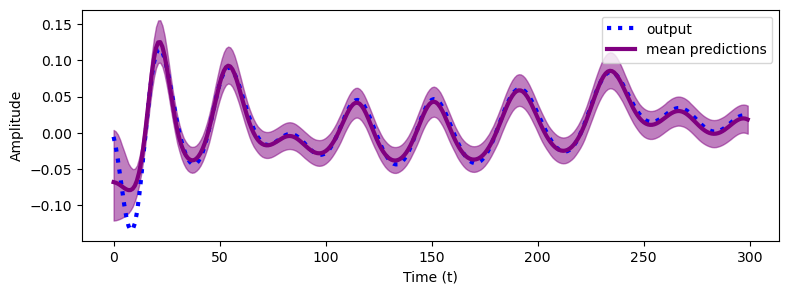

In [21]:
# Plot generated input signal
fig = plt.figure(figsize=(9,3))
ax = fig.add_subplot(111)
ax.plot(t, y_data, c="blue", lw=3, ls=":", label="output"); 
ax.plot(t, mu["mean"], c="purple", lw=3, label="mean predictions")
ax.fill_between(t, mu["5%"], mu["95%"], color="purple", alpha=0.5)
ax.set_xlabel("Time (t)");
ax.set_ylabel("Amplitude");
ax.legend();

In [22]:
plt.savefig("figures/bayesian-linear-regression.png");

<Figure size 640x480 with 0 Axes>

## Model 2: Bayesian neural network

In [14]:
# Define network architecture
neural_network = nn.Sequential(
     nn.Linear(2, 32),
     nn.Sigmoid(),
     nn.Linear(32, 1)
 )
 
module.to_pyro_module_(neural_network)
 
for m in neural_network.modules():
    for name, value in list(m.named_parameters(recurse=False)):
        setattr(m, name, module.PyroSample(prior=dist.Normal(0, 1).expand(value.shape).to_event(value.dim())))

In [15]:
class BayesianNeuralNetwork(PyroModule):
    def __init__(self, neural_network):
        super().__init__()
        self.neural_network = neural_network

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        mean = self.neural_network(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

In [16]:
# Define model and inference procedure
model = BayesianNeuralNetwork(neural_network)
guide = AutoDiagonalNormal(model)
optimizer = Adam({"lr": 0.03}) 
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

In [17]:
pyro.clear_param_store()

# Train model
num_iterations = 1500
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x_data, y_data)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / T))

[iteration 0001] loss: 3.5478
[iteration 0101] loss: 0.8152
[iteration 0201] loss: 0.6511
[iteration 0301] loss: 0.5436
[iteration 0401] loss: 0.0745
[iteration 0501] loss: -0.4262
[iteration 0601] loss: 0.8053
[iteration 0701] loss: -0.8227
[iteration 0801] loss: -0.0452
[iteration 0901] loss: -1.1197
[iteration 1001] loss: -1.2740
[iteration 1101] loss: -1.2054
[iteration 1201] loss: 0.4296
[iteration 1301] loss: -1.0471
[iteration 1401] loss: -1.5048


### Model evaluation

In [18]:
# Make predictions
predictive = Predictive(model, guide=guide, num_samples=800, return_sites=("linear.weight", "obs", "_RETURN"))
samples = predictive(x_data)
pred_summary = summary(samples)
mu = pred_summary["_RETURN"]

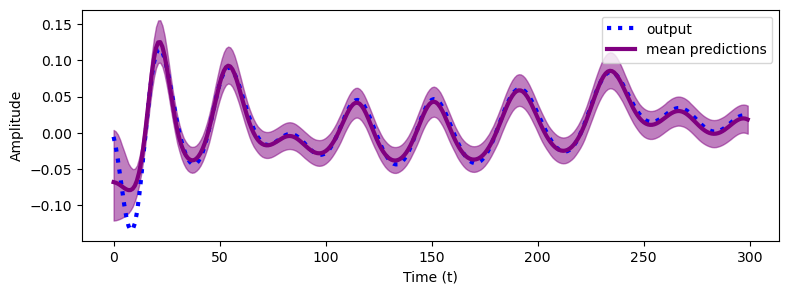

In [23]:
# Plot generated input signal
fig = plt.figure(figsize=(9,3))
ax = fig.add_subplot(111)
ax.plot(t, y_data, c="blue", lw=3, ls=":", label="output"); 
ax.plot(t, mu["mean"], c="purple", lw=3, label="mean predictions")
ax.fill_between(t, mu["5%"], mu["95%"], color="purple", alpha=0.5)
ax.set_xlabel("Time (t)");
ax.set_ylabel("Amplitude");
ax.legend();

In [24]:
plt.savefig("figures/bayesian-neuralnetwork-regression.png");

<Figure size 640x480 with 0 Axes>